In [1]:
from collections import namedtuple
import jax
import jax.numpy as jnp
import jax.scipy as jsp
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.transforms import Affine2D
import mpl_toolkits.axisartist.floating_axes as floating_axes
import pandas as pd
from pathlib import Path
from functools import partial
import itertools
from itertools import combinations
import re
import requests
import json
import scipy as sp
import scipy.stats
import sklearn
import sys
import time
import pyext.src.pynet_rng as rng
import timeit
import pyext.src.matrix as mat
import pyext.src.stats as stats

from src.wishart_synthetic_benchmark import (
    ccscatter,
    df_from_stats,
    get_precision_matrix_stats,
    get_prior_pred,
    helper_vline_hist,
    margins_plot,
    quad_plot,
    randPOSDEFMAT,
    rprior,
    rprior_pred,
    sample_from_prior,
    scatter_plot,
    simulate_from_prior,
    try_sampling
    
)

In [2]:
# Flags
MICRO_BENCHMARK_SAMPLING = False
eig10k = False
PAIR_PLOTS = False

In [3]:
# Global Notebook Variables
key = jax.random.PRNGKey(13)
n = 4
shape = 1
dim = 4
df = 2
p = 4

# Image Generating Values From a 2-d Gaussian

xy = -0.9
xx = 1.
yy = 1.
cov = jnp.array([[xx, xy],
                 [xy, yy]])
N=1000

mean = jnp.zeros(2)
data = jax.random.multivariate_normal(key, mean, cov, shape=(N,))

In [4]:
x_stats = stats.get_stats(data[:, 0])
y_stats = stats.get_stats(data[:, 1])

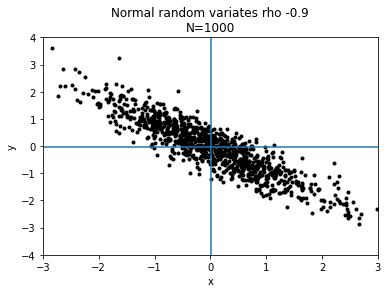

In [5]:
scatter_plot(data[:, 0], data[:, 1], xy=xy)

/home/aji/anaconda3/envs/pynetp3.10.0/lib/python3.10/site-packages/matplotlib/axes/_base.py:2475: UserWarning: Warning: converting a masked element to nan.
  xys = np.asarray(xys)


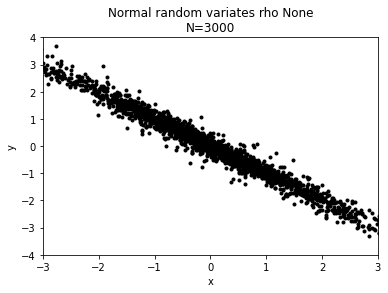

In [6]:
scale = 1.
xy = -0.99
cov_prior = jnp.array([[scale, xy],
                       [xy, scale]])

assert mat.is_positive_definite(cov_prior)

n_samples = 1000
val = jax.jit(partial(get_prior_pred, V=cov_prior, n_samples=n_samples))(key)

x = np.ravel(val.data[:, :, 0])
y = np.ravel(val.data[:, :, 1])
scatter_plot(x, y, )

In [7]:
# What is the largest Matrix this will work on?
if MICRO_BENCHMARK_SAMPLING:
    for p in [24, 48, 96, 128, 256, 512, 1024]:
        try_sampling(key, p)

In [8]:
# What about inverse Covariance Matrices?

"""
Synthetic Data Setup
  64 member pulldown
  4 replicates
  Correlation Structure
    view the image
  mean vector
  
  view the correlation matrix
  view the empircal correlation
  view the precision matrix

Model - Prior Predictive Check
    K ~ Wish
    Sigma = inv(K)
    D ~ N(0, Sigma)
    
Gaussian Model
Updated.
"""

'\nSynthetic Data Setup\n  64 member pulldown\n  4 replicates\n  Correlation Structure\n    view the image\n  mean vector\n  \n  view the correlation matrix\n  view the empircal correlation\n  view the precision matrix\n\nModel - Prior Predictive Check\n    K ~ Wish\n    Sigma = inv(K)\n    D ~ N(0, Sigma)\n    \nGaussian Model\nUpdated.\n'

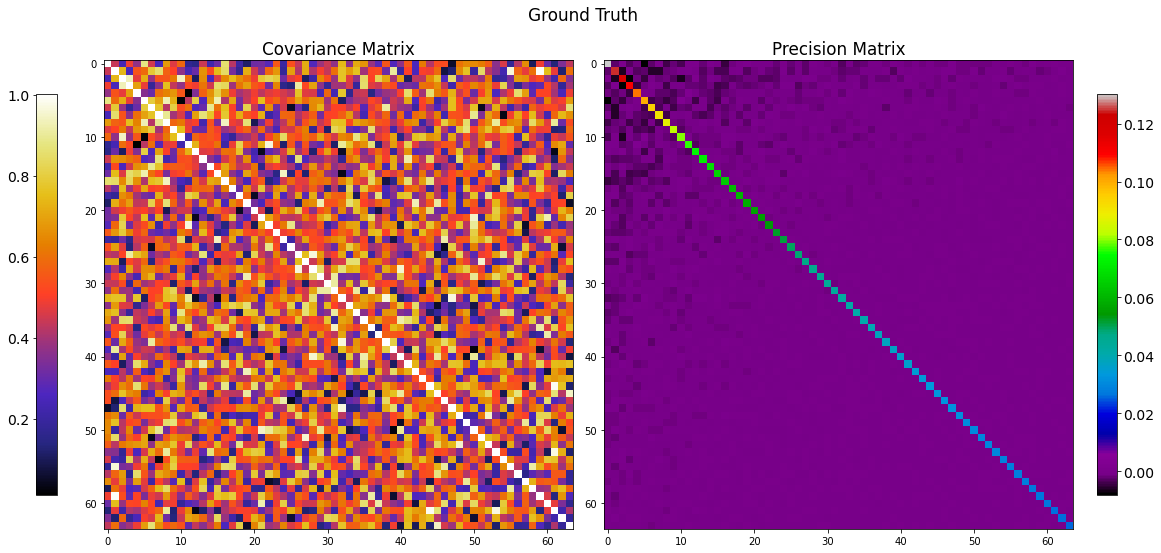

In [9]:
p = 64
k = jax.random.PRNGKey(234762834)
k, k1, k2 = jax.random.split(k, 3)
A = randPOSDEFMAT(k, p)
diag_idx = np.diag_indices(p)
A = A.at[diag_idx].set(jnp.sqrt(A[diag_idx]) + jnp.arange(p) / 2).block_until_ready()
A = np.array(A)
assert np.alltrue(A[diag_idx] > 0)
assert mat.is_positive_definite(A)

n_replicates = 4
mus = jax.random.normal(k1, shape=(p,))*5
data = jax.random.multivariate_normal(k2, mus, A, shape=(n_replicates,))

assert mat.is_positive_definite(A)

K = np.linalg.inv(A)
assert np.alltrue(K[diag_idx] > 0)
assert np.alltrue(K[diag_idx] > 0)
assert mat.is_positive_definite(K)
#K =  K / np.abs((np.max(K) - np.min(K))) # put two -1, 1
#K = K * 2

font_rc = {"size": 14, "family": "sans-serif"}

scale = 16
w = 1 * scale
h = 1 * scale
cmap1 = "CMRmap"#"nipy_spectral" #"CMRmap"\
cmap2 = "nipy_spectral"
cbar_scale = 0.35

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 1],
                                           'height_ratios':[1]}, layout="constrained")

plt.rc("font", **font_rc)
fig.set_figheight(h)
fig.set_figwidth(w)
ax = axs[0]


covim = ax.imshow(A, vmin=np.min(A), vmax=2*np.median(A), cmap=cmap1)
fig.colorbar(covim, ax=ax, location="left", shrink=0.35)
ax.set_title("Covariance Matrix")

ax = axs[1]
ax.set_title("Precision Matrix")
precim = ax.imshow(K, vmin=np.min(K), vmax=np.max(K), cmap=cmap2)
fig.colorbar(precim, ax=ax, location="right", shrink=cbar_scale)
plt.suptitle("Ground Truth", y=0.75)
plt.show()

The covariance matrix $A$  
The precision matrix $K=A^{-1}$

In the covariance matrix the off diagonal elements are only dependant on columns X and Y

#### Covariance Matrix $A$
- Diagonals are the Variances
- Off Diagonals are the Covariances (un-normalized correlation)

#### Correlation Matrix corr:
- The covariance matrix of standardized normal variates
- The diagonals are 1
- The off-diagonals are the correlations
  
#### Precision Matrix $K$
$$p_{ij} = K_{ij}$$ Precision matrix off diagonal
partial_correlation 
$$\rho_{X_iX_j\cdot V}=-\frac{K_{ij}}{\sqrt{p_{ii}p_{ij}}}$$



In [10]:

data = np.array(data)
data = data.T
data = pd.DataFrame(data=data)
data["means"] = data.apply(np.mean, axis=1)
data["stds"] = data.apply(np.std, axis=1)
data["vars"] = data.apply(np.var, axis=1)
data["medians"] = data.apply(np.median, axis=1)
diag_idx = np.diag_indices(p)
data["mu"] = np.array(mus)
data["Aii"] = np.array(A[diag_idx])
data["Kii"] = np.array(K[diag_idx])

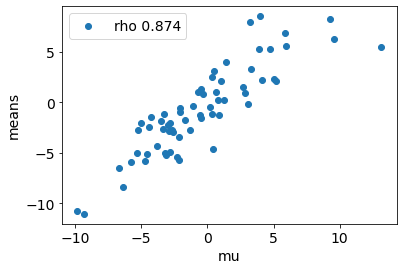

In [11]:
ccscatter(data.mu, data.means)

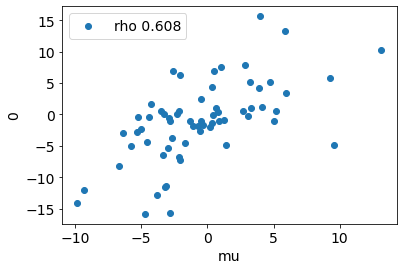

In [12]:
ccscatter(data.mu, data.loc[:, 0])

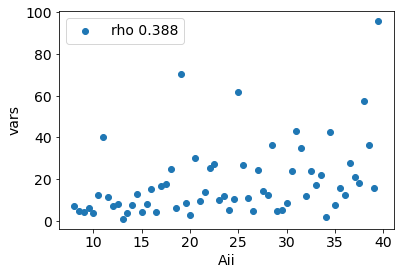

In [13]:
ccscatter(data.Aii, data.vars)

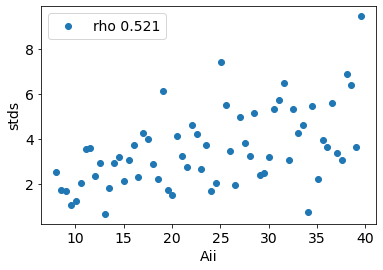

In [14]:
ccscatter(data.Aii, data.stds)

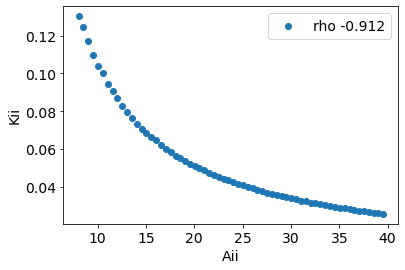

In [15]:
ccscatter(data.Aii, data.Kii)

#### Model 1
 - 64 Independant Gaussians parameterized by their mean and variance
 $$p(d_i | \mu_i, \tau_i) = N(\mu, \tau)$$
 $$ \mu \sim N(\mu_0, 1)$$
 $$ \tau \sim \text{Beta} $$
 $$d_i \sim N(\mu, \tau) $$ 
 
#### Model 2

$$ D \sim N(\mu, \Sigma^{-1})$$

$$ \mu \sim N(\mu_0, \tau_0) $$

$$ \Sigma^{-1} \sim \mathcal{W}_p(\nu, K_0)$$
 - Data $D$ with $n$ replicates and $p$ nodes
 - A $p$ variate Gaussian distribution with
 - $\nu$ degrees of freedom
 - $V$ scale matrix
 - $K_0 = V^{-1}$
 - $n$ observations
 - $p$ variables
 - $Z = D \cdot D^{T}$
 $$ D \sim W_{p}(n + \nu, \space K_0 + Z^{-1}) $$
 
#### Prior Predicitve Check Metrics

#### Prior Comparisons to Ground Truth

$$ K \sim \mathcal{W}_p(\nu, K_0) $$

- sum of the rows
- sum of the columns
- sum of the trace
- min
- max

#####  p-variate metrics
- mean values
- medians
- variances
- min
- max

##### Eigen-values

In [16]:
K_0 = jnp.ones(p) * 0.5 + jnp.eye(p)
n_samples = 1000

jss = jax.jit(partial(sample_from_prior, K_0=K_0, nu=p, p=p, n_samples=n_samples))

val = jss(key)

mat_stats = [get_precision_matrix_stats(K, n) for K in val.samples]

prior_mat_stat_df = df_from_stats(mat_stats, n)
#prior_mat_stat_df = prior_mat_stat_df.iloc[:, 1:-1]

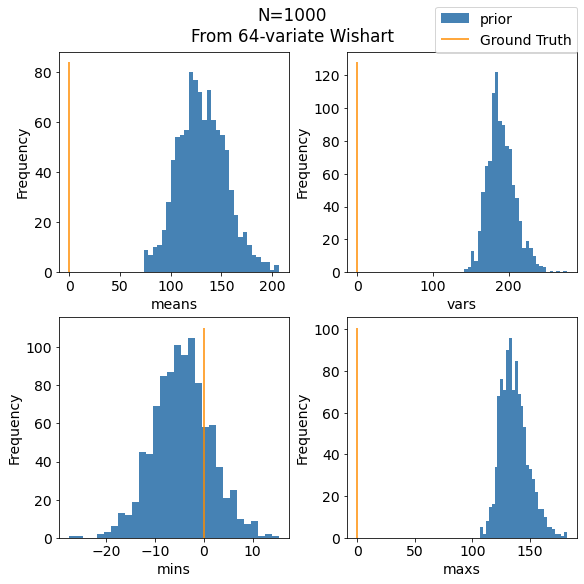

In [17]:
# Initial Model Results
suptitle = f"N={n_samples}\nFrom {p}-variate Wishart"
quad_plot(prior_mat_stat_df, K, n, n_samples, font_rc=font_rc, p=p, suptitle=suptitle)

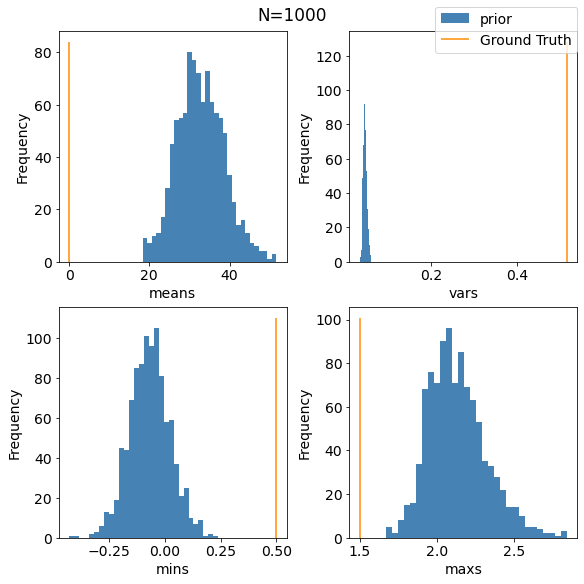

In [18]:
# Try a new K0, reuse key
p=64
n=64
ground_truth = K_0
K0 = 1/n * K_0
n_samples = 1000
jss = jax.jit(partial(sample_from_prior, K_0=K0, nu=p, p=p, n_samples=n_samples))
val = jss(key)
stats = [get_precision_matrix_stats(K, n) for K in val.samples]
df = df_from_stats(stats, n)
quad_plot(df, ground_truth, n_samples=n_samples,
         n=n,
         font_rc=font_rc, p=p)

In [19]:
# Try a new K0, reuse key

p=64
n=64
K0 = 1/n * K
n_samples = 10000
jss = jax.jit(partial(sample_from_prior, K_0=K0, nu=p, p=p, n_samples=n_samples))
val = jss(key)
stats = [get_precision_matrix_stats(K, n) for K in val.samples]
df = df_from_stats(stats, n=n)

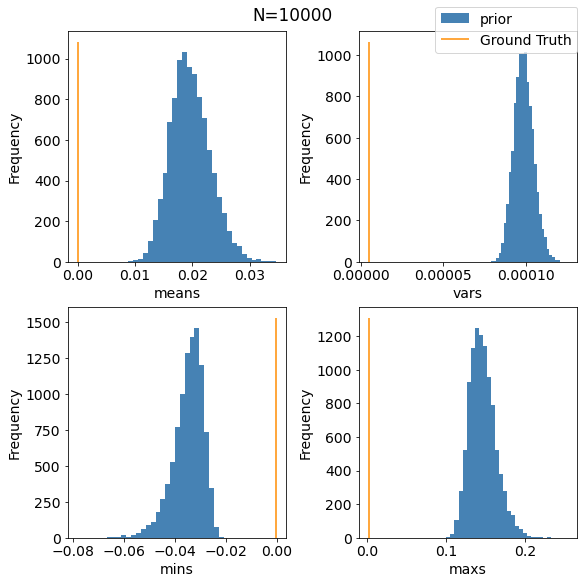

In [20]:
quad_plot(df, K0, n=n, n_samples=n_samples, font_rc=font_rc, p=p)

In [21]:
# Lets look at the top 4 eigenvalues

if eig10k:
    ground_truth = sp.linalg.eigh(K, eigvals_only=True, check_finite=True)

    eigs = np.zeros((len(val.samples), p))
    for i in range(len(val.samples)):
        eigs[i] = sp.linalg.eigh(val.samples[i], eigvals_only=True, check_finite=True)
    

In [22]:
if PAIR_PLOTS:
    m = 8
    scale = 16
    w = 1 * scale
    h = 1 * scale
    bins=30
    hcolor="steelblue"
    vcolor="darkorange"
    fig, axs = plt.subplots(m, m, layout="constrained")
    fig.set_figheight(h)
    fig.set_figwidth(w)

    count = -1
    for i in range(m):
        for j in range(m):
            count +=1
            ax = axs[i, j]
            eigvals = eigs[:, count]
            vx = ground_truth[count]
            ymin = 0

            vlabel = f"K eigenvalues" if count == m*m-1 else None
            hlabel = f"prior samples" if count == m*m-1 else None

            #helper_vline_hist(ax, vx, ymin, ymax, eigvals, vlabel, hlabel,
                             #vcolor, hcolor, bins, ylabel=None, xlabel=None)



            ax.hist(eigvals, bins=bins, label=hlabel, facecolor=hcolor)
            ymax = ax.get_ylim()[1]
            ax.vlines(x=truth, ymin=0, ymax=ymax, color=vcolor)

            #ax.scatter(x, y)
        plt.suptitle(f"N={n_samples}")
    plt.show()

In [23]:
# A simpler Case

cov = np.array([[1., -0.2],
                [-0.2, 1.]])

cov_inv = sp.linalg.inv(cov)
nu = 2
n=2
p = 2
K0 = (1/nu)*cov_inv
n_samples = 1000

key = jax.random.PRNGKey(22)
samples = sample_from_prior(key, nu, p, n_samples, K0)

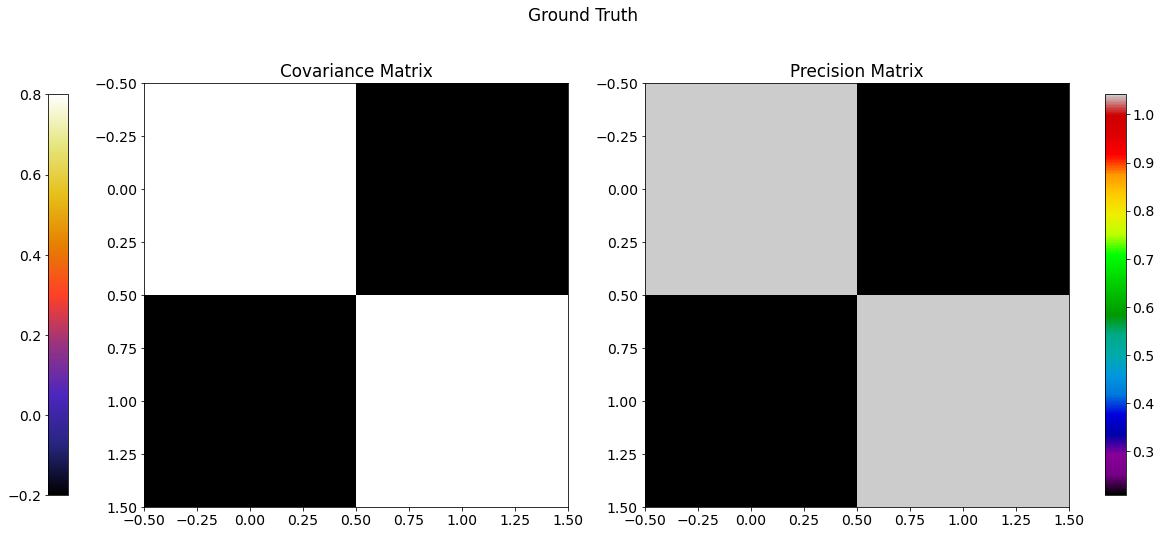

In [24]:
t1 = A
t2 = K
A = cov
K = cov_inv
font_rc = {"size": 14, "family": "sans-serif"}

scale = 16
w = 1 * scale
h = 1 * scale
cmap1 = "CMRmap"#"nipy_spectral" #"CMRmap"\
cmap2 = "nipy_spectral"
cbar_scale = 0.35

fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 1],
                                           'height_ratios':[1]}, layout="constrained")

plt.rc("font", **font_rc)
fig.set_figheight(h)
fig.set_figwidth(w)
ax = axs[0]


covim = ax.imshow(A, vmin=np.min(A), vmax=2*np.median(A), cmap=cmap1)
fig.colorbar(covim, ax=ax, location="left", shrink=0.35)
ax.set_title("Covariance Matrix")

ax = axs[1]
ax.set_title("Precision Matrix")
precim = ax.imshow(K, vmin=np.min(K), vmax=np.max(K), cmap=cmap2)
fig.colorbar(precim, ax=ax, location="right", shrink=cbar_scale)
plt.suptitle("Ground Truth", y=0.75)
plt.show()
A = t1
K = t2

In [25]:
mat_stats = [get_precision_matrix_stats(K, n, p=p) for K in samples.samples]

prior_mat_stat_df = df_from_stats(mat_stats, n)

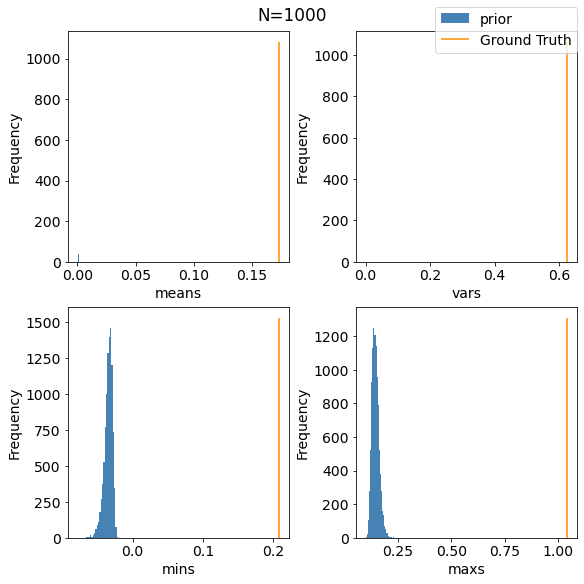

In [26]:
quad_plot(df, cov_inv, n=n, n_samples=n_samples, font_rc=font_rc, p=p)

In [27]:
ground_truth = sp.linalg.eigh(cov_inv, eigvals_only=True, check_finite=True)

eigs = np.zeros((len(samples.samples), p))
for i in range(len(samples.samples)):
    eigs[i] = sp.linalg.eigh(samples.samples[i], eigvals_only=True, check_finite=True)

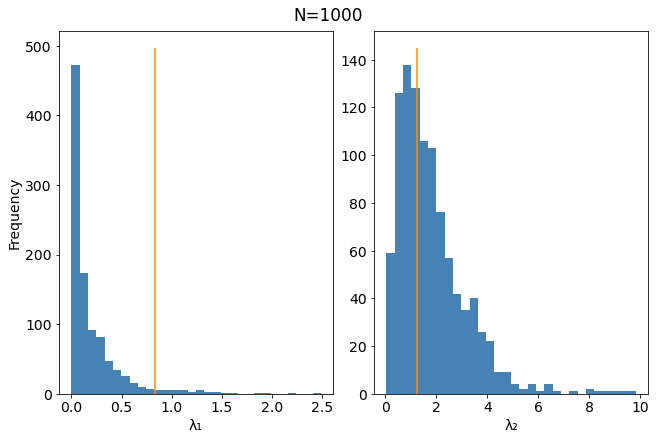

In [28]:
m = 2
scale = 6
w = 1.5 * scale
h = 1 * scale
bins=30
hcolor="steelblue"
vcolor="darkorange"

font_rc = {"size": 16, "family": "sans-serif"}
fig, axs = plt.subplots(1, 2, layout="constrained")
fig.set_figheight(h)
fig.set_figwidth(w)

count = -1
axs[0].set_ylabel("Frequency")
for i in range(m):
    count +=1
    ax = axs[i]
    eigvals = eigs[:, count]
    vx = ground_truth[count]
    ymin = 0

    vlabel = f"K eigenvalues" if count == m*m-1 else None
    hlabel = f"prior samples" if count == m*m-1 else None

    #helper_vline_hist(ax, vx, ymin, ymax, eigvals, vlabel, hlabel,
                     #vcolor, hcolor, bins, ylabel=None, xlabel=None)


    truth = ground_truth[count]
    ax.hist(eigvals, bins=bins, label=hlabel, facecolor=hcolor)
    ymax = ax.get_ylim()[1]
    ax.vlines(x=truth, ymin=0, ymax=ymax, color=vcolor)

    s = u"\u03BB"
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    s = s + str(count + 1)
    s = s.translate(SUB)
    ax.set_xlabel(s)
    #ax.scatter(x, y)
    
    plt.suptitle(f"N={n_samples}")
plt.show()

In [29]:
# More Complex 3 x 3

cov = np.array([[1., 0., 0.2],
                [0., 0.3, -0.5],
                [0.2, -0.5, 1.3]])

assert mat.is_positive_definite(cov)

cov_inv = sp.linalg.inv(cov)
nu = 3
n=3
p = 3
K0 = (1/nu)*cov_inv
n_samples = 1000

key = jax.random.PRNGKey(22)

samples = sample_from_prior(key, nu, p, n_samples, K0)

In [30]:
mat_stats = [get_precision_matrix_stats(K, n, p=p) for K in samples.samples]

prior_mat_stat_df = df_from_stats(mat_stats, n)

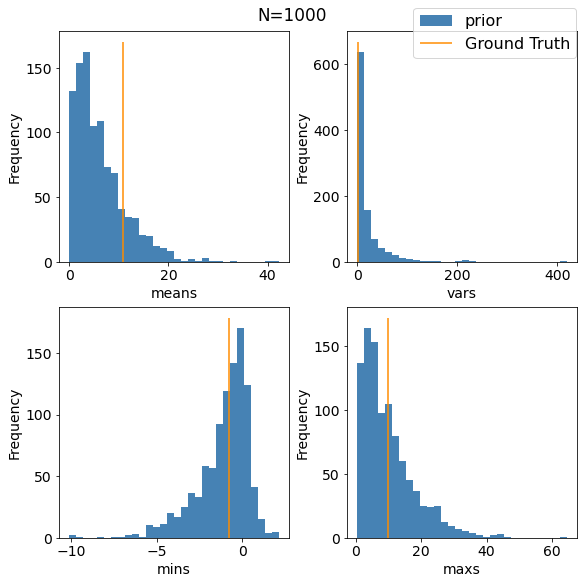

In [31]:
quad_plot(prior_mat_stat_df, cov_inv, n=n, n_samples=n_samples, font_rc=font_rc, p=p)

In [32]:
ground_truth = sp.linalg.eigh(cov_inv, eigvals_only=True, check_finite=True)

eigs = np.zeros((len(samples.samples), p))
for i in range(len(samples.samples)):
    eigs[i] = sp.linalg.eigh(samples.samples[i], eigvals_only=True, check_finite=True)

In [33]:
assert ground_truth.shape == (3,)
assert eigs.shape == (n_samples, 3)

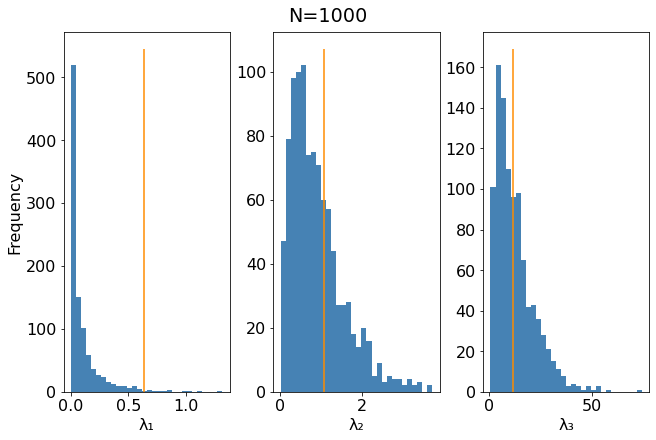

In [34]:
m = 3
scale = 6
w = 1.5 * scale
h = 1 * scale
bins=30
hcolor="steelblue"
vcolor="darkorange"

font_rc = {"size": 16, "family": "sans-serif"}
fig, axs = plt.subplots(1, m, layout="constrained")
fig.set_figheight(h)
fig.set_figwidth(w)

count = -1
axs[0].set_ylabel("Frequency")
for i in range(m):
    count +=1
    ax = axs[i]
    eigvals = eigs[:, count]
    vx = ground_truth[count]
    ymin = 0

    vlabel = f"K eigenvalues" if count == m*m-1 else None
    hlabel = f"prior samples" if count == m*m-1 else None

    #helper_vline_hist(ax, vx, ymin, ymax, eigvals, vlabel, hlabel,
                     #vcolor, hcolor, bins, ylabel=None, xlabel=None)


    truth = ground_truth[count]
    ax.hist(eigvals, bins=bins, label=hlabel, facecolor=hcolor)
    ymax = ax.get_ylim()[1]
    ax.vlines(x=truth, ymin=0, ymax=ymax, color=vcolor)

    s = u"\u03BB"
    SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
    s = s + str(count + 1)
    s = s.translate(SUB)
    ax.set_xlabel(s)
    #ax.scatter(x, y)
    
    plt.suptitle(f"N={n_samples}")
plt.show()

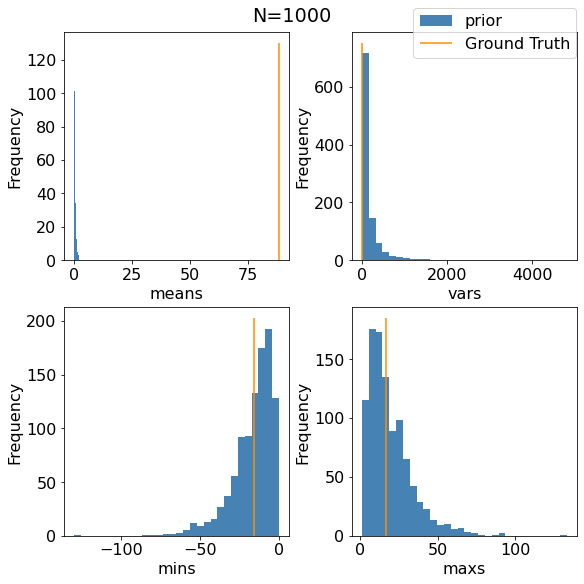

In [35]:
# More Complex 4x4
def set_up_synth_exp(key, nu, cov,):
    SynthExper = namedtuple("SynthExp", "cov cov_inv nu n p K0 n_samples key samples")
    assert mat.is_positive_definite(cov)

    cov_inv = sp.linalg.inv(cov)
    n=len(cov)
    p = len(cov)
    K0 = (1/nu)*cov_inv
    n_samples = 1000

    key = jax.random.PRNGKey(22)

    samples = sample_from_prior(key, nu, p, n_samples, K0)
    return SynthExper(cov, cov_inv, nu, n, p, K0, n_samples, key, samples)

cov = np.array([[1.1,  0.0, 0.1, 1.],
                [0.,  1.2, 1., 0.],
                [0.1, 1.0,  1.1,0.],
                [1.,  0.,  0., 1.]])


def check_cov(m):
    assert np.alltrue(m[np.diag_indices(len(m))] > 0), f"fail : diag"
    assert np.alltrue(cov == cov.T)
    assert mat.is_positive_definite(m), f"fail pos"
    
def do_quad_plot(exp, font_rc={"size": 16}):
    mat_stats = [get_precision_matrix_stats(S, exp.n, p=exp.p) for S in exp.samples.samples]
    prior_mat_stat_df = df_from_stats(mat_stats, exp.n)
    quad_plot(prior_mat_stat_df, exp.cov_inv, n=exp.n, n_samples=exp.n_samples, font_rc=font_rc, p=exp.p)

key = jax.random.PRNGKey(4)
ex4 = set_up_synth_exp(key, nu, cov)
do_quad_plot(ex4)

In [433]:
def do_gridplot(
    exp,
    scale = 6,
    w = 1.5 * scale,
    h = 1 * scale,
    bins=30,
    hcolor="steelblue",
    vcolor="darkorange",

    font_rc = {"size": 16, "family": "sans-serif"}, 
    check_finite=True,
    decomposition="eigh"):
    
    

    if decomposition == "eigh":
        def decomp(x):
            return sp.linalg.eigh(x, eigvals_only=True, check_finite=check_finite)
    
    elif decomposition == "svd":
        def decomp(x):
            U, s, VH = sp.linalg.svd(x)
            return s
    elif decomposition == "prec":
        def decomp(x):
            return x[np.diag_indices(len(x))]
        
    ground_truth = decomp(exp.cov_inv)
    
    eigs = np.zeros((len(exp.samples.samples), exp.p))
    
    
    for i in range(len(exp.samples.samples)):
        eigs[i] = decomp(exp.samples.samples[i])
    
    
    
    assert len(exp.cov) % 2 == 0, f"rank cov is odd"
    m = int(np.sqrt(len(exp.cov)))
    fig, axs = plt.subplots(m, m, layout="constrained")
    fig.set_figheight(h)
    fig.set_figwidth(w)

    count = -1
    axs[0, 0].set_ylabel("Frequency")
    

    
    for i in range(m):
        for j in range(m):
            count +=1
            ax = axs[i, j]
            eigvals = eigs[:, count]
            vx = ground_truth[count]
            ymin = 0

            vlabel = f"K eigenvalues" if count == m*m-1 else None
            hlabel = f"prior samples" if count == m*m-1 else None

            #helper_vline_hist(ax, vx, ymin, ymax, eigvals, vlabel, hlabel,
                             #vcolor, hcolor, bins, ylabel=None, xlabel=None)


            truth = ground_truth[count]
            ax.hist(eigvals, bins=bins, label=hlabel, facecolor=hcolor)
            ymax = ax.get_ylim()[1]
            ax.vlines(x=truth, ymin=0, ymax=ymax, color=vcolor)
            
            if decomposition == "eigh":
                s = u"\u03BB"

            elif decomposition == "svd":
                s = u"\u03C3"
            
            elif decomposition == "prec":
                s = f"p"

            SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
            s = s + str(count + 1)
            s = s.translate(SUB)
            ax.set_xlabel(s)
            #ax.scatter(x, y)

            plt.suptitle(f"N={n_samples}")
    #plt.legend()
    plt.show()

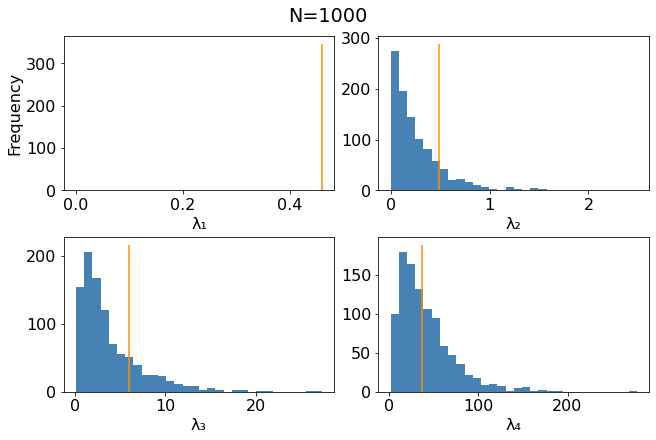

In [37]:
do_gridplot(ex4)

In [206]:
key = jax.random.PRNGKey(1123123)
key, k1 = jax.random.split(key, 2)
p = 16
nu = p
A = jax.random.uniform(key, shape=(p, p)).block_until_ready()

A = A @ A.T
A = A / (np.sqrt(A) @ np.sqrt(A))
A = A + np.eye(p)
A = np.array(A)
A[0, 3] = 0
A[3, 0] = 0

check_cov(A)
exp = set_up_synth_exp(k1, nu, A) # check invertible, pos def

check_cov(exp.cov_inv) # check inverse

assert np.alltrue(np.isnan(exp.K0)==False)
assert np.alltrue(np.isinf(exp.K0)==False)
assert np.alltrue(np.isnan(exp.samples.samples)==False)

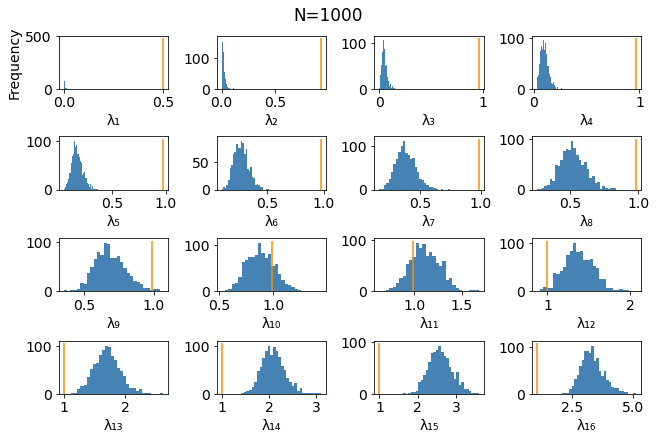

In [207]:
do_gridplot(exp)

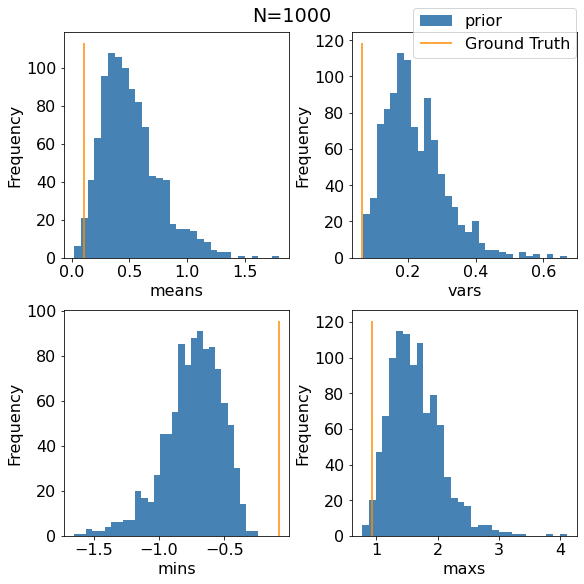

In [40]:
do_quad_plot(exp)

In [537]:
"""
Let's Do an Example with an 8 x 8 matrix
"""
p=4 # The length of the date vector
nu = p
n_trial = 4 # The number of AP-MS trials
factor = 4

# Generate the Ground Truth Network
key = jax.random.PRNGKey(22)
keys = jax.random.split(key, 10)
A = jax.random.bernoulli(keys[0], shape=(p, p))
diag_idx = np.diag_indices(p)
A = np.tril(A) + np.tril(A).T
A = np.array(A)
A[diag_idx] = 0
A = np.array(A, dtype=int)

# Generate the K_theta, the simulate known precicion matrix

K_theta = jax.random.uniform(keys[1], minval=-1., maxval=1.,  shape=(p, p))
K_theta = np.array(K_theta)
K_theta /= factor
K_theta[np.where(A == 0)] = 0
K_theta = np.tril(K_theta, k=-1) + np.tril(K_theta, k=-1).T
K_theta[diag_idx] = 3 + 4*jax.random.normal(keys[2], shape=(p,))/4

check_cov(K_theta)
#assert np.sum(K_theta[diag_idx]) == p

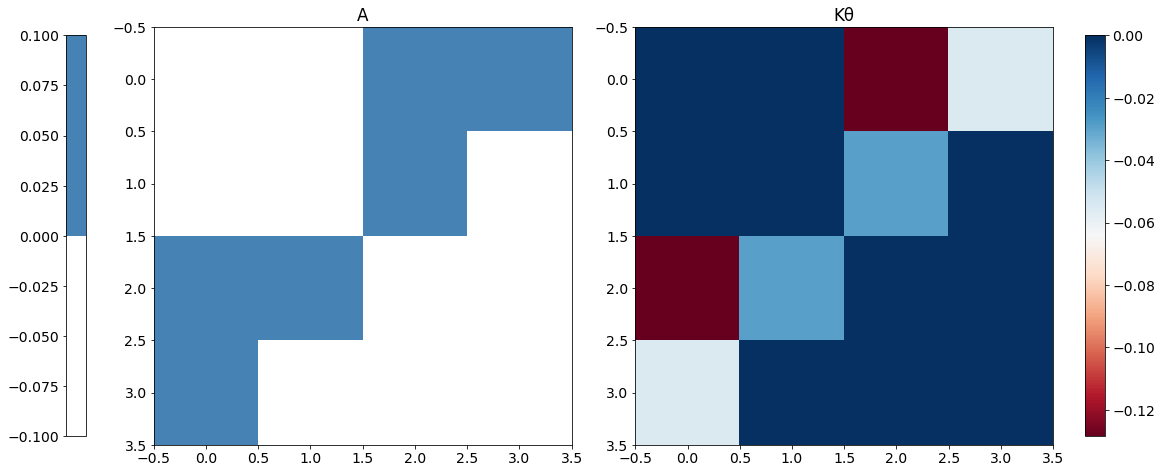

In [538]:
def ground_truth_pair_plot(A, K, title1="", title2="", cmap1="nipy_spectral", cmap2="CMRmap", factor=1.):
    font_rc = {"size": 14, "family": "sans-serif"}

    scale = 16
    w = 1 * scale
    h = 1 * scale
    cbar_scale = 0.35

    fig, axs = plt.subplots(1, 2, gridspec_kw={'width_ratios':[1, 1],
                                               'height_ratios':[1]}, layout="constrained")

    plt.rc("font", **font_rc)
    fig.set_figheight(h)
    fig.set_figwidth(w)
    ax = axs[0]


    covim = ax.imshow(A, vmin=np.min(A), vmax=2*np.median(A), cmap=cmap1)
    fig.colorbar(covim, ax=ax, location="left", shrink=cbar_scale)
    ax.set_title(title1)
    #ax.legend()

    ax = axs[1]
    ax.set_title(title2)
    
   # if type(cmap2) == str:
   #     cmap2 = matplotlib.colors.Colormap(cmap2)
    K_plot = K.copy()
    
    K_plot[np.diag_indices(len(K_plot))] = np.max(np.tril(K_plot, k=-1))
    
    precim = ax.imshow(K_plot, vmin=np.min(K_plot), cmap=cmap2)
    
    #bounds = [-1/factor, 1/factor]
    #cnorm = matplotlib.colors.BoundaryNorm(bounds, cmap2.N)

    fig.colorbar(precim, ax=ax, location="right", shrink=cbar_scale)
    #plt.suptitle(, y=0.75)
    plt.show()
    
cmap1 = matplotlib.colors.ListedColormap(['w', 'steelblue'])


ground_truth_pair_plot(A, K_theta, title1="A", 
                       title2="K" + u"\u03B8"
                       , cmap1=cmap1,
                       cmap2 = "RdBu")

check_cov(K_theta)

In [539]:
def get_exp(key, nu, p, n, n_samples, V, K_theta, K0, n_trial):
    keys = jax.random.split(key)
    Ks = sample_from_prior(keys[0], nu, p, n_samples, V)
    K_theta = np.array(K_theta)
    K0 = np.array(K0)
    SynthExper = namedtuple("SynthExp", "cov cov_inv nu n p K0 n_samples key samples")
    exp = SynthExper(np.array(jsp.linalg.inv(K_theta)), K_theta, nu, n_trial, p, K0, n_samples, keys[1], Ks)
    return exp

In [540]:
# p length of the data vector
#assert np.sum(K_theta[diag_idx]) == p, f"{p, np.sum(K_theta[diag_idx])}"


K0 = np.ones(shape=(p, p)) * -0.1
#diag_K0 = jax.random.uniform(keys[2], minval=0, maxval=0.01, shape=(p, ))
K0[np.diag_indices(p)] = 1
check_cov(K0)
n_samples = 1000
V = K0 / p

check_cov(V)

In [541]:
def get_exp(key, nu, p, n, n_samples, V, K_theta, K0, n_trial):
    keys = jax.random.split(key)
    Ks = sample_from_prior(keys[0], nu, p, n_samples, V)
    K_theta = np.array(K_theta)
    K0 = np.array(K0)
    SynthExper = namedtuple("SynthExp", "cov cov_inv nu n p K0 n_samples key samples")
    exp = SynthExper(np.array(jsp.linalg.inv(K_theta)), K_theta, nu, n_trial, p, K0, n_samples, keys[1], Ks)
    return exp

In [552]:
nu = 13
exp = get_exp(key, nu, p, n, n_samples, V, K_theta, K0, n_trial)


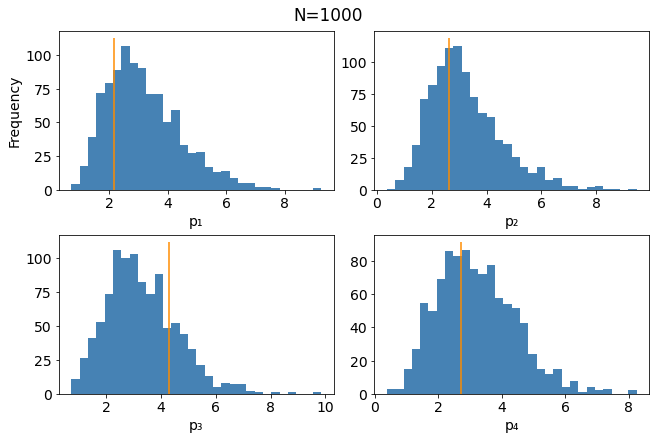

In [553]:
do_gridplot(exp, check_finite=False, decomposition="prec")

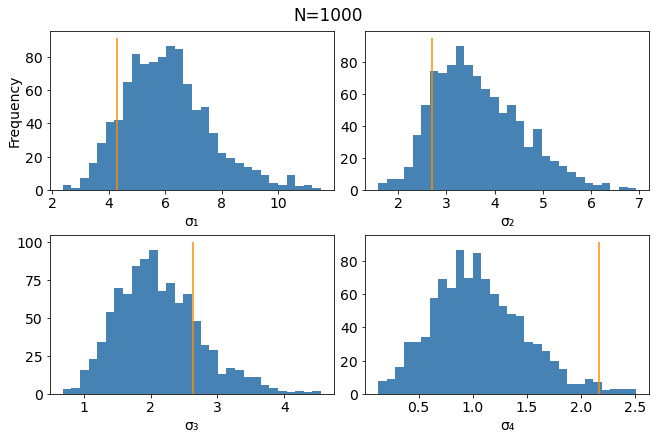

In [554]:
do_gridplot(exp, decomposition="svd")

In [529]:
K0 = K_theta
diag = np.diag_indices(p)
#diag_K0 = jax.random.uniform(keys[2], minval=0, maxval=0.01, shape=(p, ))

check_cov(K0)
n_samples = 1000

V = K0 / p

check_cov(V)

In [530]:
Ks = sample_from_prior(keys[3], nu, p, n_samples, V)
K_theta = np.array(K_theta)
K0 = np.array(K0)

In [531]:
SynthExper = namedtuple("SynthExp", "cov cov_inv nu n p K0 n_samples key samples")
nu = 14
exp = SynthExper(np.array(jsp.linalg.inv(K_theta)), np.array(K_theta), nu, n_trial, p, K0, n_samples, keys, Ks)

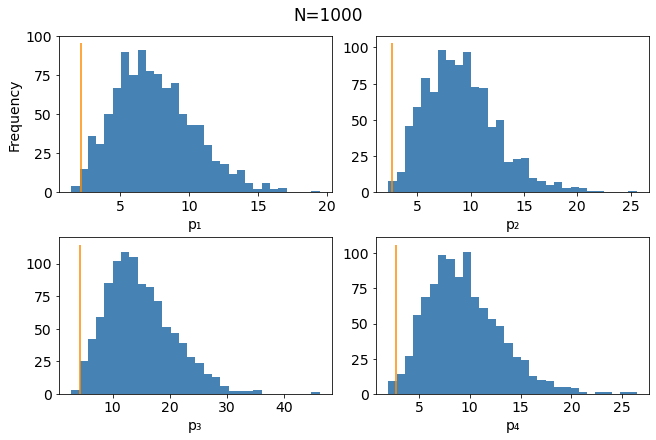

In [532]:
do_gridplot(exp, decomposition="prec")

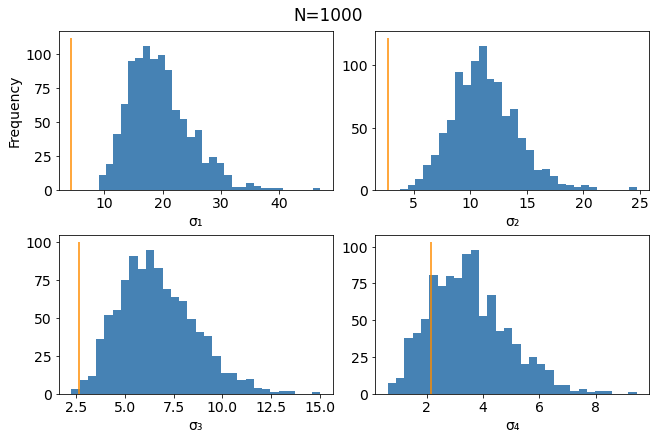

In [533]:
do_gridplot(exp, decomposition="svd")

In [ ]:
# Conclusion - setting a prior of K_theta is worse. Perhaps because of the zeros

In [491]:
# p length of the data vector
#assert np.sum(K_theta[diag_idx]) == p, f"{p, np.sum(K_theta[diag_idx])}"


K0 = np.eye(p)
diag = np.diag_indices(p)
#diag_K0 = jax.random.uniform(keys[2], minval=0, maxval=0.01, shape=(p, ))
K0[diag] = 1
check_cov(K0)
n_samples = 1000

V = K_theta

check_cov(V)

In [492]:
Ks = sample_from_prior(keys[3], nu, p, n_samples, V)
K_theta = np.array(K_theta)
K0 = np.array(K0)

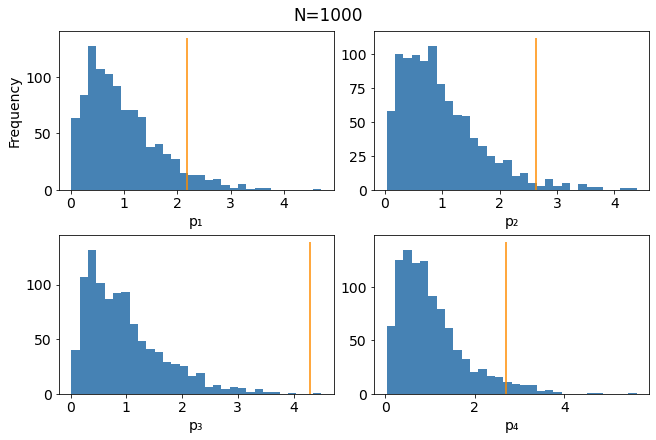

In [493]:
# sp.linalg.eigh
do_gridplot(exp, check_finite=False, decomposition="prec")

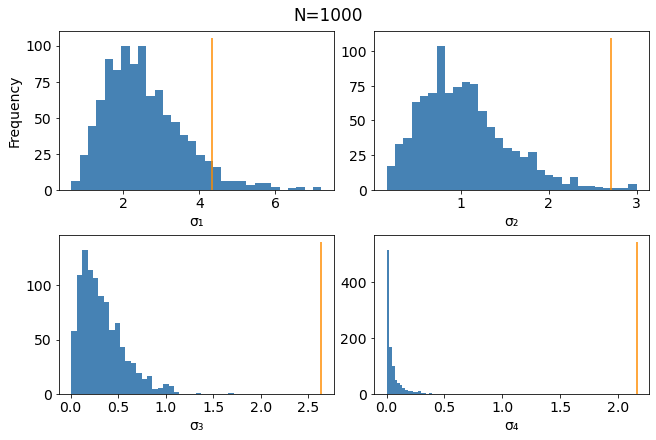

In [495]:
do_gridplot(exp, decomposition="svd")

In [469]:
Sigma = jsp.linalg.inv(K_theta)


array([[ 2.05675316e+00,  1.20890319e-01,  0.00000000e+00,
         2.44303524e-01, -2.26745009e-01,  0.00000000e+00,
         1.02219701e-01,  0.00000000e+00, -1.52290165e-01,
        -1.28016710e-01, -2.12889254e-01, -1.61796629e-01,
         4.54499125e-02,  6.97953701e-02,  2.23184526e-01,
         0.00000000e+00],
       [ 2.29250848e-01,  3.86202884e+00,  0.00000000e+00,
        -1.40078723e-01, -2.01271772e-01,  0.00000000e+00,
        -1.56746924e-01,  0.00000000e+00,  1.98626041e-01,
         0.00000000e+00, -2.29740083e-01,  1.94030941e-01,
         0.00000000e+00,  0.00000000e+00, -1.47356391e-02,
         3.23284864e-02],
       [ 0.00000000e+00,  0.00000000e+00,  4.60842991e+00,
        -1.61415935e-02, -4.63635325e-02,  5.44865727e-02,
         3.23710442e-02, -2.19702303e-01,  0.00000000e+00,
         4.46878672e-02,  0.00000000e+00,  1.40641570e-01,
         2.40763545e-01,  0.00000000e+00, -1.66426361e-01,
         0.00000000e+00],
       [-2.36681700e-01, -6.17027879e

In [481]:
rng.wishart(keys[1], K_theta, 14, len(K_theta))

DeviceArray([[ 1.40350266e+01, -6.66085863e+00, -6.42477417e+00,
               5.65205574e+00, -7.47179568e-01, -4.18651724e+00,
               2.78228688e+00,  1.79848278e+00,  6.89896107e-01,
              -1.29032052e+00,  2.12632513e+00,  5.35054493e+00,
              -1.66166440e-01, -5.52433538e+00, -7.64540052e+00,
               2.47197843e+00],
             [-6.66085863e+00,  5.37184868e+01, -1.47218475e+01,
              -3.77555346e+00,  6.00273430e-01,  2.09273281e+01,
               1.50416069e+01,  2.18940884e-01, -1.47076073e+01,
               1.01008463e+01, -6.45637512e+00, -1.73869820e+01,
              -1.01303711e+01, -1.36814957e+01, -1.08851280e+01,
              -6.33876324e+00],
             [-6.42477417e+00, -1.47218475e+01,  5.78050194e+01,
               3.41841865e+00, -1.02712059e+01, -6.60140705e+00,
               1.48947680e+00,  1.27747269e+01, -1.53427391e+01,
              -4.80507803e+00, -8.70459652e+00, -3.99435735e+00,
              -6.34071970e

In [478]:
K_theta.shape

(16, 16)

In [269]:
U, s, Vh = scipy.linalg.svd(K_theta)

In [447]:
_, s1, u = sp.linalg.svd(K_theta)

In [442]:
_, s2, u = sp.linalg.svd(K0)

In [448]:
s1

array([2.0094483 , 1.9453267 , 1.7098715 , 1.6628286 , 1.5425252 ,
       1.4041774 , 1.3301711 , 1.2337784 , 1.2005459 , 0.7248908 ,
       0.69617933, 0.67424625, 0.46738097, 0.26575464, 0.15878642,
       0.05493155], dtype=float32)

In [94]:
n_close = 0
nk = sp.special.binom(p, 2)
ACC = np.zeros(len(Ks.samples))
PREC = np.zeros(len(Ks.samples))
for i, sample in enumerate(Ks.samples):
    assert sample.shape == (p, p)
    minv = np.min(sample)
    maxv = np.max(sample)
    assert minv < 0
    assert maxv > 0
    
    d = maxv - minv
    percent = 0.01
    
    P = np.abs(sample) < d*percent
    P = np.array(P)
    P[diag] = 0
    ACC[i] = 0.5*np.sum(P == A) / nk
    
    
    
n_close /= n_samples

Text(0.5, 0, 'Accuracy')

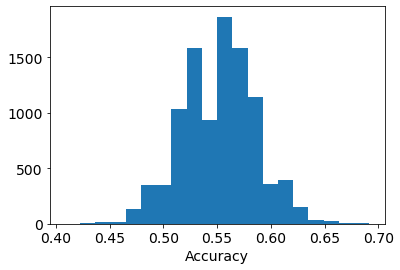

In [97]:
plt.hist(ACC, bins=20)
plt.xlabel("Accuracy")

In [ ]:
example_string = "A0B1C2D3E4F5G6H7I8J9"

SUB = str.maketrans("0123456789", "₀₁₂₃₄₅₆₇₈₉")
SUP = str.maketrans("0123456789", "⁰¹²³⁴⁵⁶⁷⁸⁹")

print(example_string.translate(SUP))
print(example_string.translate(SUB))

In [ ]:
matplotlib.colors.Colormap(cmap1)

In [98]:
A

array([[0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0],
       [1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1],
       [0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0],
       [1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0],
       [1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1],
       [0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0],
       [1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1],
       [1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0],
       [1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0],
       [1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1],
       [1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1],
       [1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1],
       [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0]])

In [ ]:
class FunctionSpace:
    """
    A vector space of functions from x in X to y in Y
    F: X -> Y
    """
    def __init__(self, f):
        if type(f) == FunctionSpace:
            self.f = f.f
        else:
            self.f = f
        
    def __call__(self, x):
        return self.f(x)
    
    def __add__(self, g):
        return FunctionSpace(lambda x: self.f(x) + g(x)) # be a member of the vector space
    
    def __radd__(self, g):
        return FunctionSpace(lambda x: self.f(x) + g(x))
    
    def __sub__(self, g):
        return FunctionSpace(lambda x: self.f(x) - g(x))
    
    def __rsub__(self, g):
        return FunctionSpace(lambda x: g(x) - self.f(x))
    
    def __mul__(self, lam):
        # scalar multiplication
        return FunctionSpace(lambda x: self.f(x) * lam)   
    
    def __rmul__(self, lam):
        return FunctionSpace(lambda x: self.f(x) * lam)

In [ ]:
fs = FunctionSpace

def f(x):
    return np.sqrt(x + 1)

def g(x):
    return x**2 + 2

def h(x):
    return x**2 + 9 / 3

def z(x):
    return x + 1

def q(x):
    return x + 1

In [ ]:
# Check our Assumptions

f = fs(f)
h = fs(h)
g = fs(g)

xs = [0, 2., np.array([[0, 1, 2],
                       [1., 1., -3.]])]

for x in xs:
    # Commutative over addition
    np.testing.assert_almost_equal( (f + g)(x), (g + f)(x)), f"{x}"

    # Scalar Multiplication
    np.testing.assert_almost_equal(0 * (f + h)(x), 0 * (h + f)(x))
    np.testing.assert_almost_equal(123 * (f + h)(x), (123 * f + 123 * h)(x))

    # Ascociative

    assert (h + (f + g))(3) == ((h + f) + g)(3)

    assert (f - f)(123498723489) == 0 # Additive Inverse


In [ ]:
np.sqrt(-3)

In [ ]:
(g+f)(0)

In [ ]:
# vf \in FS
# Python Functions

In [ ]:
(f + g) == (g + f)

In [ ]:
hash(f + g)

In [ ]:
hash((g + f).f)

In [ ]:


hash(g - f) == hash(g - f)

In [ ]:
def eq(x, y):
    return x == y

In [ ]:
jax.make_jaxpr(eq)(x, x)

In [ ]:
jax.make_jaxpr(f + g)(x)

In [ ]:
hash(f)

In [ ]:
jax.make_jaxpr(f - g)(x)

In [ ]:
(f - g)(2)

In [ ]:
(g - f)(2)